In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')


In [33]:
# Load dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

# Combine for quick exploration
df = pd.concat([X, y], axis=1)
df.head()

# Dataset shape and class balance
print("Shape:", df.shape)
print("\nClass distribution:\n", df["target"].value_counts())

# Check for missing values
print("\nMissing values:\n", df.isnull().sum().sum())


Shape: (569, 31)

Class distribution:
 target
1    357
0    212
Name: count, dtype: int64

Missing values:
 0


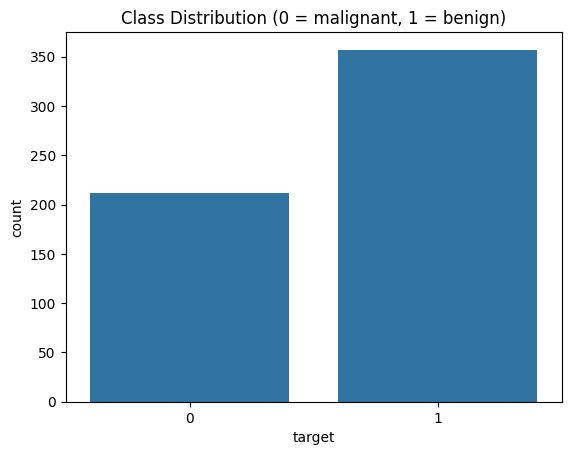

In [34]:
sns.countplot(x="target", data=df)
plt.title("Class Distribution (0 = malignant, 1 = benign)")
plt.show()


In [35]:
from sklearn.model_selection import train_test_split

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training size:", X_train.shape)
print("Test size:", X_test.shape)


Training size: (455, 30)
Test size: (114, 30)


In [36]:
from sklearn.preprocessing import StandardScaler

# Initialize and fit scaler on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [37]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)

    print(f"--- {name} ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc:.4f}\n")

    return {"model": name, "accuracy": acc, "f1": f1, "roc_auc": roc}


In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Initialize models
logreg = LogisticRegression(max_iter=1000, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Evaluate
results = []
results.append(evaluate_model("Logistic Regression", logreg, X_train_scaled, y_train, X_test_scaled, y_test))
results.append(evaluate_model("Random Forest", rf, X_train_scaled, y_train, X_test_scaled, y_test))
results.append(evaluate_model("XGBoost", xgb, X_train_scaled, y_train, X_test_scaled, y_test))


--- Logistic Regression ---
Accuracy: 0.9825
F1 Score: 0.9861
ROC AUC: 0.9954

--- Random Forest ---
Accuracy: 0.9561
F1 Score: 0.9655
ROC AUC: 0.9939

--- XGBoost ---
Accuracy: 0.9561
F1 Score: 0.9660
ROC AUC: 0.9901



In [39]:
import pandas as pd

results_df = pd.DataFrame(results)
results_df.sort_values(by="roc_auc", ascending=False)


,model,accuracy,f1,roc_auc
0,Logistic Regression,0.982456,0.986111,0.995370
1,Random Forest,0.956140,0.965517,0.993882
2,XGBoost,0.956140,0.965986,0.990079


In [40]:
from sklearn.utils import resample

def get_subsample(X, y, frac=0.2, random_state=42):
    X_sub, y_sub = resample(X, y, 
                            replace=False, 
                            n_samples=int(frac * len(X)), 
                            stratify=y, 
                            random_state=random_state)
    return X_sub, y_sub

# Example: 20% subset
X_small, y_small = get_subsample(X_train_scaled, y_train, frac=0.2)


In [41]:
from imblearn.over_sampling import SMOTE

def augment_with_smote(X, y):
    sm = SMOTE(random_state=42)
    X_aug, y_aug = sm.fit_resample(X, y)
    return X_aug, y_aug

X_aug, y_aug = augment_with_smote(X_small, y_small)


In [42]:
# Without augmentation
print("Training on small raw dataset")
evaluate_model("XGBoost - Small", xgb, X_small, y_small, X_test_scaled, y_test)

# With augmentation
print("Training on SMOTE-augmented dataset")
evaluate_model("XGBoost - Augmented", xgb, X_aug, y_aug, X_test_scaled, y_test)


Training on small raw dataset
--- XGBoost - Small ---
Accuracy: 0.9386
F1 Score: 0.9510
ROC AUC: 0.9812

Training on SMOTE-augmented dataset
--- XGBoost - Augmented ---
Accuracy: 0.9386
F1 Score: 0.9510
ROC AUC: 0.9869



{'model': 'XGBoost - Augmented',
 'accuracy': 0.9385964912280702,
 'f1': 0.951048951048951,
 'roc_auc': np.float64(0.9869378306878307)}

In [43]:
import numpy as np

def inject_gaussian_noise(X, noise_level=0.05):
    noise = np.random.normal(loc=0.0, scale=noise_level, size=X.shape)
    X_noisy = X + noise
    return X_noisy
X_noisy = inject_gaussian_noise(X_small, noise_level=0.05)
print("Training on Gaussian Noised Data")
evaluate_model("XGBoost - Gaussian Noise", xgb, X_noisy, y_small, X_test_scaled, y_test)



Training on Gaussian Noised Data
--- XGBoost - Gaussian Noise ---
Accuracy: 0.9386
F1 Score: 0.9510
ROC AUC: 0.9863



{'model': 'XGBoost - Gaussian Noise',
 'accuracy': 0.9385964912280702,
 'f1': 0.951048951048951,
 'roc_auc': np.float64(0.9862764550264551)}

In [44]:
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata
import pandas as pd

def generate_with_ctgan(X, y, epochs=300):
    # Step 1: Combine X and y into a DataFrame
    df = pd.DataFrame(X, columns=[f"f{i}" for i in range(X.shape[1])])
    df['target'] = y.values if hasattr(y, 'values') else y

    # Step 2: Auto-detect metadata
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(df)

    # Step 3: Initialize CTGANSynthesizer
    model = CTGANSynthesizer(
        metadata,
        enforce_min_max_values=True,
        enforce_rounding=False,
        epochs=epochs
    )

    # Step 4: Train and sample
    model.fit(df)
    synthetic = model.sample(len(df))

    # Step 5: Split synthetic data
    y_synth = synthetic['target']
    X_synth = synthetic.drop('target', axis=1).values

    return X_synth, y_synth

# Generate and evaluate
X_ctgan, y_ctgan = generate_with_ctgan(X_small, y_small)
evaluate_model("XGBoost - CTGAN", xgb, X_ctgan, y_ctgan, X_test_scaled, y_test)


--- XGBoost - CTGAN ---
Accuracy: 0.9211
F1 Score: 0.9412
ROC AUC: 0.9643



{'model': 'XGBoost - CTGAN',
 'accuracy': 0.9210526315789473,
 'f1': 0.9411764705882353,
 'roc_auc': np.float64(0.9642857142857143)}

In [45]:
from imblearn.over_sampling import SMOTE

def generate_with_smote(X, y):
    sm = SMOTE(random_state=42)
    X_resampled, y_resampled = sm.fit_resample(X, y)
    return X_resampled, y_resampled

# Apply SMOTE
X_smote, y_smote = generate_with_smote(X_small, y_small)
evaluate_model("XGBoost - SMOTE", xgb, X_smote, y_smote, X_test_scaled, y_test)


--- XGBoost - SMOTE ---
Accuracy: 0.9386
F1 Score: 0.9510
ROC AUC: 0.9869



{'model': 'XGBoost - SMOTE',
 'accuracy': 0.9385964912280702,
 'f1': 0.951048951048951,
 'roc_auc': np.float64(0.9869378306878307)}

In [46]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd

def generate_with_mixup(X, y, alpha=0.4):
    # Convert y to NumPy array and one-hot encode
    y_array = y.to_numpy().reshape(-1, 1) if hasattr(y, 'to_numpy') else y.reshape(-1, 1)
    encoder = OneHotEncoder(sparse_output=False)
    y_encoded = encoder.fit_transform(y_array)

    # Convert X to NumPy array if it's a DataFrame
    X_array = X.to_numpy() if hasattr(X, 'to_numpy') else X

    idx1 = np.arange(len(X_array))
    idx2 = np.random.permutation(len(X_array))
    lam = np.random.beta(alpha, alpha, len(X_array))[:, None]

    X_mix = lam * X_array[idx1] + (1 - lam) * X_array[idx2]
    y_mix = lam * y_encoded[idx1] + (1 - lam) * y_encoded[idx2]
    y_mix_labels = np.argmax(y_mix, axis=1)

    # Return as NumPy arrays
    return X_mix, y_mix_labels

X_mixup, y_mixup = generate_with_mixup(X_small, y_small)
evaluate_model("XGBoost - Mixup", xgb, X_mixup, y_mixup, X_test_scaled, y_test)



--- XGBoost - Mixup ---
Accuracy: 0.9474
F1 Score: 0.9595
ROC AUC: 0.9825



{'model': 'XGBoost - Mixup',
 'accuracy': 0.9473684210526315,
 'f1': 0.9594594594594594,
 'roc_auc': np.float64(0.9824735449735449)}